Purpose: To investigate what fraction of the PHAs (or NEOs) might be discovered before or during LSST operations by other telescope, and then add these to LSST's total to see the effect of LSST + previous discoveries. 

As we use synthetic model populations (not actual populations) and do not know the survey pointing history for previous surveys, we simulate what would have been "previously discovered" by taking our model population and identifying a V magnitude threshhold which matches approximately what is known now or what will be known at the start of LSST operations. 

As a proxy for simulating the entire population + pointing histories for existing surveys, we can assume that all NEOs larger than 140m which get brighter than a given V magnitude threshhold will be discovered. Spacewatch has been in operation since 1984, CSS has been a considerable influence in NEO discovery since 2005, etc. According to the JPL NEO discovery page (http://neo.jpl.nasa.gov/stats/) we could estimate conservatively that discovery of 140m NEOs started in earnest in 2000 -- implying (a conservative) 15 years to reach the current 25% level (and the discovery rate of 140m and larger NEOs seems roughly constant over that time period, with a recent uptick of about 20% per year).  GMS16 (https://arxiv.org/pdf/1604.03444v1.pdf) indicates that the current completeness of NEOs larger than 140m is about 25% (Mainzer et al 2011) and is expected to be 43% when LSST comes online.

Thus we take our sample of NEOs, integrate their orbits over 15 years (generating ephemerides once per night), and look at their peak brightness over that time period. We then choose a peak brightness threshhold that corresponds to detecting 25% of the total NEOs larger than 140m (H=22). 

After going through the process shown in the cells below, I find the threshhold should be V=20.0 to match current completeness after 15 years of operations, and that the expected completeness if this same rate continues should be 30% at the start of LSST. However, new assets online (such as PanSTARRS) mean that the limiting magnitude should be adjusted to a fainter limit: we use V=22 as a default.

In [1]:
# Set up basics.
import os 
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set up MAF
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.db as db
import lsst.sims.maf.metricBundles as mmb
import lsst.sims.maf.utils as utils

import sys
try:
    # remove a conflict on my personal system
    sys.path.remove('/Users/lynnej/work/lsst')
except ValueError:
    pass
sys.path.append(os.path.join(os.getenv('SIMS_MAF_DIR'), 'bin'))
import movingObjects as moO

/Users/lynnej/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Set up some basic information that we need to define orbit parameters and metric ranges.

In [3]:
orbitFile = {}
orbitFile['pha'] = 'orbits/phas_2k.des'
orbitFile['neo'] = 'orbits/neos_2k.des'

In [4]:
Hmark = 22
Hrange = np.arange(11, 28.5, 0.5)
Hidx = np.where(Hrange == 22)[0]
outDir = 'test'
if not (os.path.isdir(outDir)):
    os.makedirs(outDir)

If this notebook was previously run, or you have the information available, you can read back in the previous evaluation of the peak magnitudes and time of 'discovery' (first time V>20.0) for the 15 years from start of surveys to now, the 22 years from start of surveys to start of LSST, and the same information during the LSST survey.

In [22]:
# Read previously calculated times of discovery for LSST, for the 15 years up to 'now', for the 22 years between 
# now and LSST start, for the 10 years of LSST (for other resources) and the times of discovery for LSST back from disk

# Set up the moving object slicers for each of these ephemeride files. -- without obs data.
slicerEphsN =  {}
for t in ['neo', 'pha']:
    slicerEphsN[t] = moO.setupSlicer(orbitFile[t], Hrange, obsFile=None)

In [5]:
import os
flist = os.listdir(outDir)
knownBundle = {}
peakVBundle = {}
m1 = metrics.KnownObjectsMetric()
m2 = metrics.PeakVMagMetric()
for t in ['neo', 'pha']:
    # 15 and 22 years before LSST
    for yr in ['15', '22']:
        tp = t + yr
        knownBundle[tp] = mmb.MoMetricBundle(m1, slicerEphsN[t], None, runName="Previously known", metadata=t)
        froot = 'Previously_known_KnownObjects_%s_MOOB' % (tp)
        knownBundle[tp].fileRoot = froot
        moO.readMetricValues(knownBundle[tp], outDir)
        peakVBundle[tp] = mmb.MoMetricBundle(m2, slicerEphsN[t], None, runName="Previously known", metadata=t)
        froot = 'Previously_known_PeakVMag_%s_MOOB' % (tp)
        peakVBundle[tp].fileRoot = froot
        moO.readMetricValues(peakVBundle[tp], outDir)
    # 12 years during LSST
    tp = t + '12'
    knownBundle[tp] = mmb.MoMetricBundle(m1, slicerEphsN[t], None, runName="LSST period", metadata=t)
    froot = 'LSST_period_KnownObjects_%s_MOOB' % (t)
    knownBundle[tp].fileRoot = froot
    moO.readMetricValues(knownBundle[tp], outDir)
    peakVBundle[tp] = mmb.MoMetricBundle(m2, slicerEphsN[t], None, runName="LSST period", metadata=t)
    froot = 'LSST_period_PeakVMag_%s_MOOB' % (t)
    peakVBundle[tp].fileRoot = froot
    moO.readMetricValues(peakVBundle[tp], outDir)

IOError: File test/Previously_known_KnownObjects_neo15_MOOB.h5 does not exist

Otherwise, recalculate. Read bright object observations. I've generated ephemerides over 15 years from 2000 to 2015 (corresponding to the 15 years leading up to 'now' described above), for both NEOs and PHAs. By picking the correct V mag threshhold, we should see about 25% completeness at H=22. I've also generated ephemerides of the same objects reaching all the way to the start of LSST operations (2022), so as to calculate the expected completeness at the start of LSST operations. 

In [5]:
import pandas as pd
ephemFile = {}
ddir = '/Users/lynnej/ephems/'
ephemFile['pha15'] = os.path.join(ddir, 'phas_2k_15.dat')  # PHA ephems from 2000-2015
ephemFile['neo15'] = os.path.join(ddir, 'neos_15.dat')  # NEO ephems from 2000-2015
ephemFile['pha22'] = os.path.join(ddir, 'phas_2k_22.dat')  # PHA ephems from 2000-2022
ephemFile['neo22'] = os.path.join(ddir, 'neos_22.dat')  # NEO ephems from 2000-2022
ephemFile['pha12'] = os.path.join(ddir, 'phas_2k_12.dat')  # PHA ephems from 2022-2034
ephemFile['neo12'] = os.path.join(ddir, 'neos_12.dat')  # NEO ephems from 2022-2034

ephems = {}
for t in ephemFile:
    ephems[t] = pd.read_table(ephemFile[t], delim_whitespace=True)

In [6]:
# Add some columns to the ephem file - these are used to calculate appMagV.
def add_velocity(ephs):
    ephs['velocity'] = np.sqrt(ephs['dRAdt']**2 + ephs['dDecdt']**2)
    return ephs

def calcMagLosses(ephs, seeing=0.75, texp=30.):
    """
    Calculate the magnitude losses due to trailing and not matching the point-source detection filter.
    """
    a_trail = 0.76
    b_trail = 1.16
    a_det = 0.42
    b_det = 0.00
    x = ephs['velocity'] * texp / seeing / 24.0
    ephs['dmagTrail'] = 1.25 * np.log10(1 + a_trail*x**2/(1+b_trail*x))
    ephs['dmagDetect'] = 1.25 * np.log10(1 + a_det*x**2 / (1+b_det*x))
    return ephs

# Add some more 'dummy' columns to ephem file - these just need to be there for SNR/vis/magFilter calculation, but
# we won't use them for peakV / known object calculation.
def add_dummycols(ephs):
    ephs['magFilter'] = ephs['magV']
    ephs['fiveSigmaDepth'] = np.ones(len(ephs), float) * 28.0
    return ephs

In [7]:
for t in ephems:
    ephems[t] = add_velocity(ephems[t])
    ephems[t] = calcMagLosses(ephems[t])
    ephems[t] = add_dummycols(ephems[t])
    cols = ephems[t].columns.values
    cols[0] = 'objId'
    ephems[t].columns = cols

In [8]:
# Set up for and run evaluation of peak magnitudes and time of 'discovery metrics. 

# Set up the moving object slicers for each of these ephemeride files.
slicerEphs =  {}
for t in ephems:
    slicerEphs[t] = moO.setupSlicer(orbitFile[t[0:3]], Hrange, obsFile=None)
    #slicerEphs[t] = moO.setupSlicer(orbitFile['neo'], Hrange, obsFile=None)
    slicerEphs[t].obs = ephems[t]
    slicerEphs[t].allObs = ephems[t]
    slicerEphs[t].obsfile = ephemFile[t]

# And set up the moving object metricBundles.
plotFuncs = [plots.MetricVsH()]

knownBundle = {}
peakVBundle = {}
for t in slicerEphs:
    plotDict = {'nxbins': 200, 'nybins': 200,
                'title': '%s: %s' % ("Previously known", t)}
    
    metric = metrics.KnownObjectsMetric(vMagThresh1=20.0, vMagThresh2=22.0, tSwitch=57023)
    knownBundle[t] = mmb.MoMetricBundle(metric, slicerEphs[t], None, 
                                        runName="Previously known", metadata=t,
                                        plotDict=plotDict, plotFuncs=plotFuncs)
    

    metric = metrics.PeakVMagMetric()
    peakVBundle[t] = mmb.MoMetricBundle(metric, slicerEphs[t], None,
                                        runName="Previously known", metadata=t,
                                        plotDict=plotDict, plotFuncs=plotFuncs)

In [9]:
# Calculate  the peak V magnitude and times of 'discovery' (passing mag threshhold) for each object
for t in slicerEphs:
    bg = mmb.MoMetricBundleGroup({0:knownBundle[t], 1: peakVBundle[t]}, outDir=outDir, resultsDb=None)
    bg.runAll()

Running metrics [0, 1]


/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:121: UserWarning: Warning - column appMagV already present in simData, will be overwritten.
  %(col))
/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:121: UserWarning: Warning - column appMag already present in simData, will be overwritten.
  %(col))
/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:121: UserWarning: Warning - column SNR already present in simData, will be overwritten.
  %(col))
/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/stackers/baseStacker.py:121: UserWarning: Warning - column vis already present in simData, will be overwritten.
  %(col))
/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/stackers/moStackers.py:73: RuntimeWarning: overflow encountered in exp
  completeness = 1.0 / (1 + np.exp((ssoObs['appMag'] - ssoObs[self.m5Col])/self.sigma))


Calculated and saved all metrics.
Running metrics [0, 1]


/Users/lynnej/lsstRepos/sims_maf/python/lsst/sims/maf/stackers/moStackers.py:72: RuntimeWarning: overflow encountered in multiply
  ssoObs['SNR'] = 1.0 / np.sqrt((0.04 - self.gamma) * xval + self.gamma * xval * xval)


Calculated and saved all metrics.
Running metrics [0, 1]
Calculated and saved all metrics.
Running metrics [0, 1]
Calculated and saved all metrics.
Running metrics [0, 1]
Calculated and saved all metrics.
Running metrics [0, 1]
Calculated and saved all metrics.


Now - we need to calculate the V magnitude threshhold corresponding to discovering 25% of NEOs bigger than H=22 between 2000-2015 (i.e., in the 15 year sample). For this we just look at all peak V magnitudes, and look at the sample 'completeness' corresponding to varying the V magnitude threshhold. 

We find that 25% corresponds to a V threshhold of 20.0, which is very roughly consistent with limiting magnitudes of the biggest contributors -- Catalina Sky Survey can go to V=21.5, although threshholds described as 19-21 (probably across different weather and lunar phase?), and PS1 can go to V=22 although again much variety.

In [10]:
# routine to calculate completeness given the peakVmags metric values and a threshhold value
def calcFrac(peakVmags, Hvals, Vthresh, cumulative=True):
    nSsos = peakVmags.shape[0]
    peakVinH = peakVmags.swapaxes(0, 1)
    completeness = np.zeros(len(Hvals), float)
    for i, H in enumerate(Hvals):
        completeness[i] = np.where(peakVinH[i].filled(100) <= Vthresh)[0].size
    completeness = completeness / float(nSsos)
    if cumulative:
        completeness = metrics.integrateOverH(completeness, Hvals)
    return completeness

In [11]:
# Find the V mag threshhold corresponding to 25% completeness for H<=22, at the present time.
thresh = 20.0
comp = calcFrac(peakVBundle['neo15'].metricValues, Hrange, thresh)
print "At %f Vmag threshhold, find %f completeness for H<=22" % (thresh, comp[Hidx][0])

At 20.000000 Vmag threshhold, find 0.257953 completeness for H<=22


In [12]:
# But we should also match the completeness estimate for 1 km objects (17.75, or about 18), which is around 90%.
print "At bright end, 1km objects, find %f completeness" % (comp[np.where(Hrange==18)])

At bright end, 1km objects, find 0.953638 completeness


In [13]:
# Calculate what completeness would be with same rate/instrumentation at start of LSST.
comp = calcFrac(peakVBundle['neo22'].metricValues, Hrange, 20.0)
print 'At start of LSST operations, with same Vmag threshhold, expect %f completeness H<=22' % (comp[Hidx][0])

At start of LSST operations, with same Vmag threshhold, expect 0.295974 completeness H<=22


In [14]:
# Calculate what completeness would be with same rate/instrumentation at start of LSST for PHAs
print "Same numbers, for PHAS"
comp = calcFrac(peakVBundle['pha15'].metricValues, Hrange, thresh)
print "At %f Vmag threshhold, find %f completeness for H<=22" % (thresh, comp[Hidx][0])
comp = calcFrac(peakVBundle['pha22'].metricValues, Hrange, 20.0)
print 'At start of LSST operations, with same Vmag threshhold, expect %f completeness H<=22' % (comp[Hidx][0])

Same numbers, for PHAS
At 20.000000 Vmag threshhold, find 0.326949 completeness for H<=22
At start of LSST operations, with same Vmag threshhold, expect 0.386404 completeness H<=22


In [15]:
# Check one of Zeljko's numbers, which was fraction of the population which will not get brighter than V=24
comp = calcFrac(peakVBundle['neo22'].metricValues, Hrange, 24)
print "Fraction of the NEO population @ h<=22 which never brighter than V=24 in 22 years: %f" %(1 - comp[Hidx])
comp = calcFrac(peakVBundle['pha22'].metricValues, Hrange, 24)
print "Fraction of the PHA population @ h<=22 which never brighter than V=24 in 22 years: %f" %(1 - comp[Hidx])

Fraction of the NEO population @ h<=22 which never brighter than V=24 in 22 years: 0.030651
Fraction of the PHA population @ h<=22 which never brighter than V=24 in 22 years: 0.023292


In [18]:
# Check equivalent LSST threshhold
lsstthresh = 22.2
comp = calcFrac(peakVBundle['neo12'].metricValues, Hrange, lsstthresh)
print "At %f Vmag threshhold, find %f completeness for H<=22 during 12 years of LSST" % (lsstthresh, comp[Hidx][0])
print "This compares to 61% completeness calculated using full discovery metric in minion_1016."

At 22.200000 Vmag threshhold, find 0.640967 completeness for H<=22 during 12 years of LSST
This compares to 61% completeness calculated using full discovery metric in minion_1016.


So that tells us about what could have been discovered prior to LSST (and at the present time). 

Now let's look at what LSST would have found, with our more realistic discovery criteria (3 nights of pairs, within 30 days).  Read the discovery times data back from disk.

In [24]:
opsims = ['minion_1016', 'astro_lsst_01_1016']
obsFile = {}
dataDir = {}
for opsim in opsims:
    obsFile[opsim] = {}
    dataDir[opsim] = {}
    obsFile[opsim]['pha'] = os.path.join(opsim, '%s_2k__%s' % (opsim, 'phas_2k_obs.txt'))
    dataDir[opsim]['pha'] = os.path.join(opsim, 'phas_2k_newsky')
    obsFile[opsim]['neo'] = os.path.join(opsim, '%s_newsky__%s' % (opsim, 'neos_2k_obs.txt'))
    dataDir[opsim]['neo'] = os.path.join(opsim, 'neo_newsky')

maxYears = 12
nyears = np.arange(2, maxYears+1, 2)
nyears = np.concatenate([[1], nyears])
if maxYears not in nyears:
    nyears = np.concatenate([nyears, [maxYears]])

# Read from disk.
mtmp = metrics.DiscoveryMetric(nObsPerNight=2, tMin=0, tMax=90./60./24., nNightsPerWindow=3, tWindow=30)
metric = metrics.Discovery_TimeMetric(mtmp)
discTimes = {}
for opsim in opsims:
    discTimes[opsim] = {}
    for t in ['neo', 'pha']:
        discTimes[opsim][t] = mmb.MoMetricBundle(metric, slicerEphsN[t], None, runName=opsim, metadata=t)
        froot = '%s_Discovery_Time_%s_MOOB' % (opsim, t)
        discTimes[opsim][t].fileRoot = froot
        moO.readMetricValues(discTimes[opsim][t], dataDir[opsim][t]) 

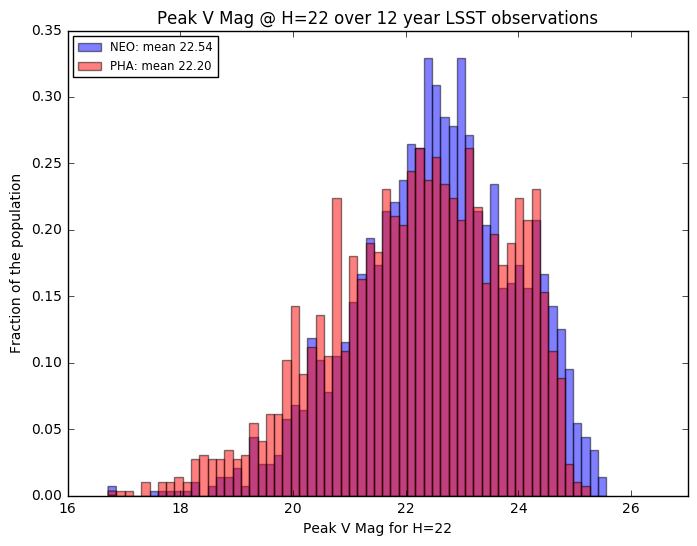

In [28]:
# Just a plot to show why completeness so different for neos vs phas
Hidx = np.where(Hrange == 22)[0]
lpha = np.swapaxes(peakVBundle['pha12'].metricValues, 0, 1)[Hidx][0]
lneo = np.swapaxes(peakVBundle['neo12'].metricValues, 0, 1)[Hidx][0]

plt.figure(figsize=(8, 6))
meanV = np.mean(lneo)
n, b, p = plt.hist(lneo, bins=60, normed=True, color='b', alpha=0.5, label='NEO: mean %.2f' % meanV)
meanV = np.mean(lpha)
n, b, p = plt.hist(lpha, bins=b, normed=True, color='r', alpha=0.5, label='PHA: mean %.2f' % meanV)
plt.xlim(16, 27)
plt.legend(loc='upper left', fontsize='smaller')
plt.title('Peak V Mag @ H=22 over 12 year LSST observations')
plt.xlabel('Peak V Mag for H=22')
plt.ylabel('Fraction of the population')
plt.savefig('lsst_peakVmag.pdf')

In [29]:
def combineTimes(discTimes1, discTimes2):
    discTimes = np.where(discTimes1.filled(100000) <= discTimes2.filled(1000000), discTimes1, discTimes2)
    mask = np.where((discTimes1.mask == True) & (discTimes2.mask == True), True, False)
    discTimes = ma.MaskedArray(data=discTimes, mask=mask, fill=-999)
    return discTimes

In [30]:
def compTime(discoveryTimes, Hvals, times, cumulative=True):
    nSsos = discoveryTimes.shape[0]
    timesinH = discoveryTimes.swapaxes(0, 1)
    completenessH = np.empty([len(Hvals), len(times)], float)
    for i, H in enumerate(Hvals):
        if len(timesinH[i].compressed()) == 0:
            completenessH[i] = np.zeros(len(times), float)
        else:
            n, b = np.histogram(timesinH[i].compressed(), bins=times)
            completenessH[i][0] = 0
            completenessH[i][1:] = n.cumsum()
    completenessH = completenessH / float(nSsos)
    completeness = completenessH.swapaxes(0, 1)
    if cumulative:
        for i, t in enumerate(times):
            completeness[i] = metrics.integrateOverH(completeness[i], Hvals)
    return completeness


minion_1016
using 10 years
NEO
At start of LSST, have 0.442 NEO completeness
Year 2031.977851
LSST only: 0.635
LSST + existing surveys: 0.739
Year 2031.977851
LSST only: 0.635
LSST + existing surveys: 0.739
PHA
At start of LSST, have 0.545 PHA completeness
Year 2031.977851
LSST only: 0.684
LSST + existing surveys: 0.828
Year 2031.977851
LSST only: 0.684
LSST + existing surveys: 0.828

astro_lsst_01_1016
using 12 years
NEO
At start of LSST, have 0.442 NEO completeness
Year 2033.976482
LSST only: 0.680
LSST + existing surveys: 0.758
Year 2031.977851
LSST only: 0.642
LSST + existing surveys: 0.737
PHA
At start of LSST, have 0.545 PHA completeness
Year 2033.976482
LSST only: 0.739
LSST + existing surveys: 0.854
Year 2031.977851
LSST only: 0.699
LSST + existing surveys: 0.831


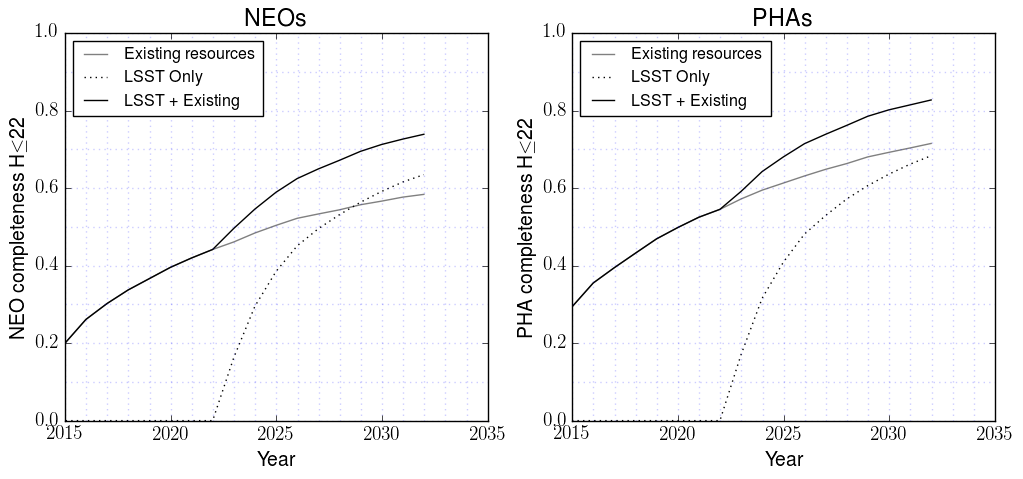

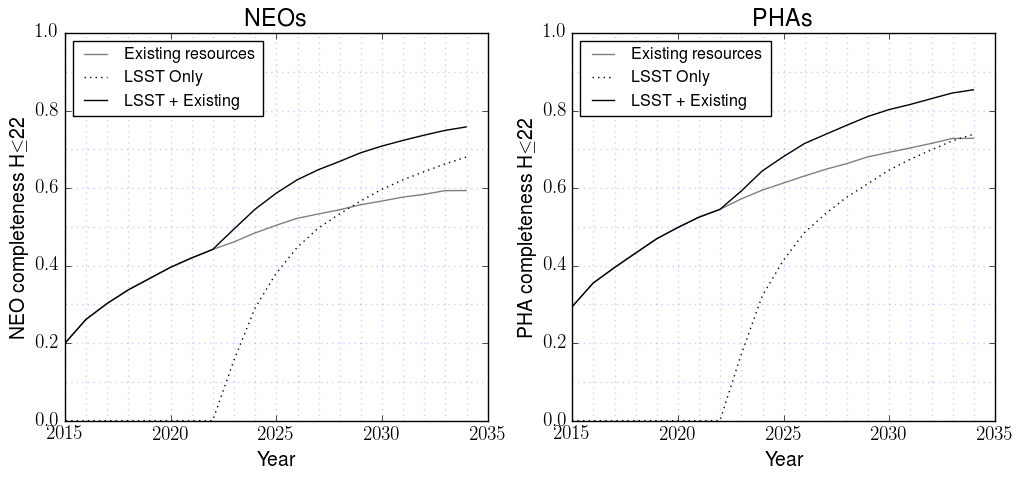

In [38]:
# Plot the cumulative completeness for H<=22 for NEOs (neo22, neo, and neo22+neo) and then PHAs
for opsim in opsims:
    print
    print opsim
    #times = np.arange(51544.16, 63230.16, 120)
    times12 = np.arange(51544.16, 63963.16, 365) 
    times10 = np.arange(51544.16, 63232.16, 365)
    yrs12 = (times12 - 57023)/365.25 + 2015
    yrs10 = (times10 - 57023)/365.25 + 2015
    if opsim == 'astro_lsst_01_1016':
        print 'using 12 years'
        yrs = yrs12
        times = times12
    else:
        print 'using 10 years'
        yrs = yrs10
        times = times10
        
    comp = {}
    other = combineTimes(knownBundle['neo22'].metricValues, knownBundle['neo12'].metricValues)
    comp['prev'] = compTime(knownBundle['neo22'].metricValues, Hrange, times)
    comp['other'] = compTime(other, Hrange, times)
    comp['lsst'] = compTime(discTimes[opsim]['neo'].metricValues, Hrange, times)
    comp['both'] = compTime(combineTimes(other, discTimes[opsim]['neo'].metricValues), Hrange, times)
    Hidx = np.where(Hrange == 22)[0][0]
    
    plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    plt.rc('font', size=14)

    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(yrs, comp['other'].swapaxes(0,1)[Hidx], color='gray', label='Existing resources')
    plt.plot(yrs, comp['lsst'].swapaxes(0,1)[Hidx], color='black', linestyle=":", label='LSST Only')
    plt.plot(yrs, comp['both'].swapaxes(0,1)[Hidx], color='black', label='LSST + Existing')
    plt.legend(loc='upper left', fontsize='smaller')
    for y in (np.arange(2015, 2035, 1)):
        plt.axvline(y, alpha=0.2, linestyle=':')
    for i in (np.arange(0, 1.1, 0.1)):
        plt.axhline(i, alpha=0.2, linestyle=':')
    plt.xlim(2015, 2035)
    plt.ylim(0, 1)
    plt.xlabel(r'Year')
    plt.ylabel(r'NEO completeness H$\leq$22')
    plt.title(r'NEOs')

    print 'NEO'
    idx = np.where(abs(yrs-2022) == abs(yrs-2022).min())[0][0]
    print 'At start of LSST, have %.3f NEO completeness' %(comp['prev'][idx][Hidx])
    print 'Year %f' %yrs[-1]
    print 'LSST only: %.3f' % (comp['lsst'][-1][Hidx])
    print 'LSST + existing surveys: %.3f' % (comp['both'][-1][Hidx])

    idx = np.where(abs(yrs-2032) == abs(yrs-2032).min())[0][0]
    print 'Year %f' %yrs[idx]
    print 'LSST only: %.3f' % (comp['lsst'][idx][Hidx])
    print 'LSST + existing surveys: %.3f' % (comp['both'][idx][Hidx])


    comp = {}
    other = combineTimes(knownBundle['pha22'].metricValues, knownBundle['pha12'].metricValues)
    comp['prev'] = compTime(knownBundle['pha22'].metricValues, Hrange, times)
    comp['other'] = compTime(other, Hrange, times)
    comp['lsst'] = compTime(discTimes[opsim]['pha'].metricValues, Hrange, times)
    comp['both'] = compTime(combineTimes(other, discTimes[opsim]['pha'].metricValues), Hrange, times)
    Hidx = np.where(Hrange == 22)[0][0]
    yrs = (times - 57023)/365.25 + 2015
    plt.subplot(1,2,2)
    plt.plot(yrs, comp['other'].swapaxes(0,1)[Hidx], color='gray', label='Existing resources')
    plt.plot(yrs, comp['lsst'].swapaxes(0,1)[Hidx], color='black', linestyle=':', label='LSST Only')
    plt.plot(yrs, comp['both'].swapaxes(0,1)[Hidx], color='black', label='LSST + Existing')
    plt.legend(loc='upper left', fontsize='smaller')
    plt.xlim(2015, 2035)
    for y in (np.arange(2015, 2035, 1)):
        plt.axvline(y, alpha=0.2, linestyle=':')
    for i in (np.arange(0, 1.1, 0.1)):
        plt.axhline(i, alpha=0.2, linestyle=':')
    plt.ylim(0, 1)
    plt.xlabel('Year')
    plt.ylabel('PHA completeness H$\leq$22')
    plt.title('PHAs')
    plt.savefig(os.path.join(outDir, opsim + '_completeness.pdf'))
    
    print 'PHA'
    idx = np.where(abs(yrs-2022) == abs(yrs-2022).min())[0][0]
    print 'At start of LSST, have %.3f PHA completeness' %(comp['prev'][idx][Hidx])
    
    print 'Year %f' %yrs[-1]
    print 'LSST only: %.3f' % (comp['lsst'][-1][Hidx])
    print 'LSST + existing surveys: %.3f' % (comp['both'][-1][Hidx])

    idx = np.where(abs(yrs-2032) == abs(yrs-2032).min())[0][0]
    print 'Year %f' %yrs[idx]
    print 'LSST only: %.3f' % (comp['lsst'][idx][Hidx])
    print 'LSST + existing surveys: %.3f' % (comp['both'][idx][Hidx])